In [67]:
import tensorflow as tf
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.estimator import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
import pandas as pd
import glob
import pathlib
import cv2

In [73]:
# Parametres
BATCH_SIZE=128
IMG_WIDTH=128
IMG_HEIGHT=128
EPOCHS=70


# create a data generator
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=45,
                             width_shift_range=.15,
                             height_shift_range=.15,
                             horizontal_flip=True,
                             zoom_range=0.5
                             )

# load and iterate training dataset
train_gen = datagen.flow_from_directory(directory='C:/Users/hakim/PycharmProjects/zindi_compet/data/train', 
                                         target_size=(IMG_WIDTH,IMG_HEIGHT), 
                                         class_mode='categorical', 
                                         color_mode='rgb', 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True, 
                                         seed=42)
# load and iterate training dataset
validation_gen = datagen.flow_from_directory(directory='C:/Users/hakim/PycharmProjects/zindi_compet/data/validation/', 
                                         target_size=(IMG_WIDTH,IMG_HEIGHT), 
                                         class_mode='categorical', 
                                         color_mode='rgb', 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True, 
                                         seed=42)
# load and iterate test dataset
test_gen = datagen.flow_from_directory(directory='C:/Users/hakim/PycharmProjects/zindi_compet/data/test1/', 
                                        target_size=(IMG_WIDTH,IMG_HEIGHT), 
                                        class_mode='categorical', 
                                        color_mode='rgb', 
                                        batch_size=10, 
                                        shuffle=True, 
                                        seed=42)

Found 723 images belonging to 3 classes.
Found 152 images belonging to 3 classes.
Found 610 images belonging to 3 classes.


(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


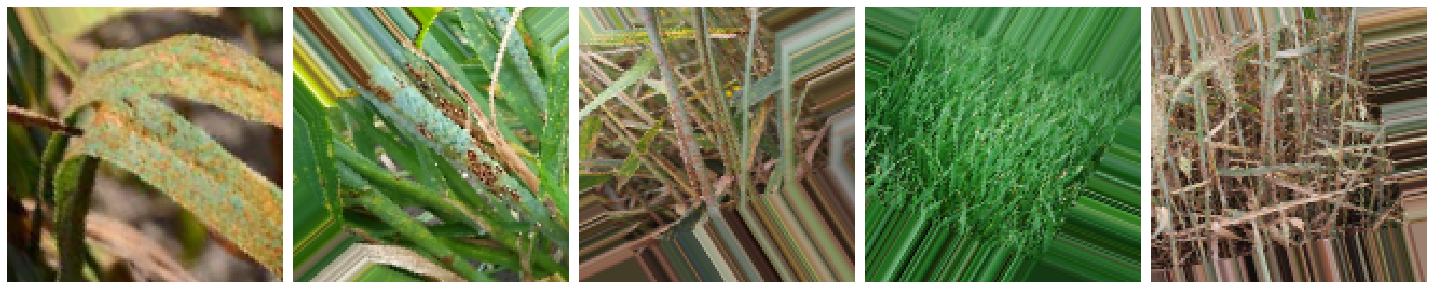

In [74]:
# plot some images
sample_training, _ = next(train_gen)

def plotImage(images):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        print(img.shape)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImage((sample_training[:5]))

In [75]:
def lr_optimizer(epoch):
    lr = 1e-3
    if (epoch == 30):
        lr *= 1e-1
    elif(epoch == 60):
        lr *= 1e-1
    else:
        lr *= 0.5e-1

In [85]:
def create_model():
    
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same',activation=relu, input_shape=(128, 128, 3)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3),padding='same', activation=relu))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation=relu))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation=relu))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512, activation=relu ))
    model.add(Dropout(0.3))

    model.add(Dense(3, activation=softmax))

# compile the model
    model.compile(loss=categorical_crossentropy,
                  metrics=['accuracy'],
                  optimizer=Adam())
    return model

In [86]:
# summary
model = create_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 64)       

In [ ]:
# train model
history=model.fit_generator(generator=train_gen, 
                    steps_per_epoch=train_gen.n//train_gen.batch_size, 
                    epochs=70,
                    validation_data=validation_gen,
                    validation_steps=validation_gen.n//validation_gen.batch_size
)

In [ ]:
# save weights
#model.save_weights('weights_first_try.h5')
#model.save('model_first_try.h5')

# load model
# from keras.models import load_model
# model = load_model('model_first_try.h5')

In [ ]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
# evaluating the model
model.evaluate_generator(generator=validation_gen,
                         steps=validation_gen.n//validation_gen.batch_size)

In [ ]:
# predict the output
test_gen.reset()
pred = model.predict_generator(test_gen,
                               steps=test_gen.n//test_gen.batch_size,
                               verbose=1)

In [ ]:
# reset the test generator
predicted_class_indices = np.argmax(pred,axis=1)

In [ ]:
# map predictions
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
predictions

In [ ]:
len(predictions)

In [ ]:
# save results
filenames = test_gen.filenames
list_file = []
for f in filenames:
    i = f.split("\\")
    f = i[1].split(".")
    print(f[0])
    list_file.append(f[0])
    
results = pd.DataFrame({"ID":list_file, "Predictions":predictions})
print(results)


results = results.join(pd.get_dummies(predictions))
results = results.drop('Predictions', axis=1)
results.ID = results.ID.map(lambda x: x[0:11])

results.to_csv("results1.csv", index=False)